In [1]:
import numpy as np
import pandas as pd
import ast
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

class Word2VecModel:
    def __init__(self, filename, embedding_dim=100, window_size=3, learning_rate=0.01, epochs=10):
        # Set device (GPU if available)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize class variables
        self.filename = filename
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # Load the data
        self.df = pd.read_csv(self.filename, header=0)
        self.df['Berita'] = self.df['Berita'].apply(ast.literal_eval)
        
        # Flatten and create vocabulary
        self.flattened_tokens = [token for tokens in self.df['Berita'] for token in tokens]
        self.word_to_id = self.create_vocabulary(self.flattened_tokens)
        
        # Generate training data
        self.training_data = self.generate_training_data(self.df['Berita'], self.word_to_id)
        
        # Initialize weights
        self.w, self.v = self.initialize_weights(len(self.word_to_id))

        # Move weights to the appropriate device
        self.w = self.w.to(self.device)
        self.v = self.v.to(self.device)

    def create_vocabulary(self, tokens):
        """Create vocabulary from tokens."""
        word_count = defaultdict(int)
        for token in tokens:
            word_count[token] += 1
        word_to_id = {word: i for i, (word, _) in enumerate(word_count.items())}
        self.word_frequencies = word_count  # Store word frequencies
        return word_to_id
    
    def get_word_frequencies(self):
        """Display the number of unique words and their frequency."""
        print(f"Total unique words: {len(self.word_frequencies)}")
        print("\nTop 20 most frequent words:")
        sorted_words = sorted(self.word_frequencies.items(), key=lambda x: x[1], reverse=True)
        for word, freq in sorted_words[:20]:
            print(f"{word}: {freq}")

    def generate_training_data(self, data, word_to_id):
        """Generate training data as context-y pairs."""
        training_data = []
        for tokens in data:
            for i, word in enumerate(tokens):
                start = max(0, i - self.window_size)
                end = min(len(tokens), i + self.window_size + 1)
                for j in range(start, end):
                    if i != j:
                        training_data.append((word_to_id[word], word_to_id[tokens[j]]))
        return training_data
    
    def initialize_weights(self, vocab_size):
        """Initialize weights for the neural network."""
        # create 
        np.random.seed(seed=42) # for reproducibility
        
        w = torch.rand(vocab_size, self.embedding_dim, device=self.device) * np.sqrt(2 / (vocab_size + self.embedding_dim)) # Input weights
        v = torch.rand(self.embedding_dim, vocab_size, device=self.device) * np.sqrt(2 / (vocab_size + self.embedding_dim)) # Output weights
        return w, v

    def one_hot_encode(self, idx, vocab_size):
        """One-hot encode the input index and return a PyTorch tensor."""
        res = torch.zeros(vocab_size, device=self.device)  # Use torch.zeros
        res[idx] = 1
        return res

    def softmax(self, x):
        """Compute the softmax of a vector manually."""
        exp_x = torch.exp(x - torch.max(x))  # Subtract max(x) to improve stability
        return exp_x / torch.sum(exp_x)

    def forward_propagation(self, target_word, w, v):
        """Perform forward propagation."""
        # Input Layer
        X = self.one_hot_encode(target_word, len(w))
        
        # Hidden Layer
        A = torch.matmul(X, w)

        # Output Layer
        B = torch.matmul(A, v)
        Z = self.softmax(B)

        return A, B, Z

    def backward_propagation(self, target_word, context_word, A, Z, w, v):
        """Perform backward propagation."""
        y = self.one_hot_encode(context_word, len(w))

        dB = Z - y
        dv = torch.outer(A, dB)
        dA = torch.matmul(dB, v.T)
        dw = torch.outer(dA, self.one_hot_encode(target_word, len(w))).T

        # Update weights
        w -= self.learning_rate * dw
        v -= self.learning_rate * dv
        return w, v

    def train_word2vec(self):
        """Train the Word2Vec model using forward and backward propagation."""
        for epoch in range(self.epochs):
            total_loss = 0
            for target_word, context_word in self.training_data:
                # Forward pass
                A, B, Z = self.forward_propagation(target_word, self.w, self.v)
                
                # Compute loss (cross-entropy loss)
                y = self.one_hot_encode(context_word, len(self.w))
                L = -torch.sum(y * torch.log(Z + 1e-9))  # Adding 1e-9 for numerical stability
                total_loss += L
                
                # Backward pass
                self.w, self.v = self.backward_propagation(target_word, context_word, A, Z, self.w, self.v)

            # Print loss for the current epoch
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {total_loss.item():.4f}")

    def save_word_vectors_to_csv(self, word_embedding):
        """Save each word's vector representation to a CSV file."""
        word_vectors = {word: self.w[idx].cpu().numpy().tolist() for word, idx in self.word_to_id.items()}
        df_word_vectors = pd.DataFrame.from_dict(word_vectors, orient='index')
        df_word_vectors.to_csv(word_embedding, index_label='Word')
        print(f"Word vectors saved to {word_embedding}")

    def aggregate_vectors_per_document(self, data):
        """Aggregate word vectors for each document."""
        V = []
        for tokens in data:
            token_indices = [self.word_to_id[word] for word in tokens if word in self.word_to_id]
            doc_vector = torch.mean(self.w[token_indices], dim=0)
            V.append(doc_vector.cpu().numpy())  # Convert to numpy array for storage
        return np.array(V)

    def save_vectors_to_csv(self, document_vector):
        """Save word2vec vectors to CSV."""
        V = self.aggregate_vectors_per_document(self.df['Berita'])
        self.df['Word2Vec Vector'] = V.tolist()
        self.df.to_csv(document_vector, index=False)
        print(f"Word2Vec vectors saved to {document_vector}")

    def plot_tsne(self):
        """Plot the t-SNE visualization of word vectors."""
        words = list(self.word_to_id.keys())
        word_vectors = np.array([self.w[self.word_to_id[word]].cpu().numpy() for word in words])
        
        tsne = TSNE(perplexity=45, n_components=2, init='pca', n_iter=2500, random_state=42)
        reduced_vectors = tsne.fit_transform(word_vectors)

        plt.figure(figsize=(12, 12))
        plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o')

        for i, word in enumerate(words):
            plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)

        plt.title(f't-SNE Visualization of Word Vectors')
        plt.savefig("tsne_plot.png")
        plt.show()

    def plot_tsne_num_words(self, num_words):
        """Plot the t-SNE visualization of the most frequent word vectors."""
        # Sort words by frequency
        sorted_words = sorted(self.word_frequencies.items(), key=lambda x: x[1], reverse=True)
        
        # Select the top `num_words`
        top_words = [word for word, _ in sorted_words[:num_words]]
        
        # Get vectors for the selected words
        word_vectors = np.array([self.w[self.word_to_id[word]].cpu().numpy() for word in top_words])

        # Apply t-SNE
        tsne = TSNE(perplexity=45, n_components=2, init='pca', n_iter=2500, random_state=42)
        reduced_vectors = tsne.fit_transform(word_vectors)

        # Plot
        plt.figure(figsize=(12, 12))
        plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o')

        for i, word in enumerate(top_words):
            plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)

        plt.title(f't-SNE Visualization of {num_words} Most Frequent Word Vectors')
        plt.savefig("tsne_top_words.png")
        plt.show()

    def plot_tsne_most_frequent_word_by_category(self, num_words, save_csv, word_frequencies):
        """Plot a t-SNE visualization of the most frequent words from each category"""
        # Create a dictionary to store the most frequent words per category
        category_word_freq = defaultdict(lambda: defaultdict(int))

        # Count word frequency per category
        for tokens, label in zip(self.df['Berita'], self.df['Label']):
            for word in tokens:
                if word in self.word_to_id:  # Ensure word exists in vocabulary
                    category_word_freq[label][word] += 1

        # Get the top N words per category and prepare data for CSV
        csv_data = []
        top_words_per_category = {}
        for category, word_freq in category_word_freq.items():
            sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:num_words]
            top_words_per_category[category] = [word for word, _ in sorted_words]
            
            # Prepare data for CSV
            for word, freq in sorted_words:
                csv_data.append({"Word": word, "Category": category, "Frequency": freq})

        # Save to CSV
        if save_csv:
            df_csv = pd.DataFrame(csv_data)
            df_csv.to_csv(word_frequencies, index=False)
            print(f"CSV file saved: {word_frequencies}")

        # Flatten list and create a mapping between words and categories
        selected_words = []
        word_categories = []
        for category, words in top_words_per_category.items():
            selected_words.extend(words)
            word_categories.extend([category] * len(words))

        # Get the word vectors
        word_vectors = np.array([self.w[self.word_to_id[word]].cpu().numpy() for word in selected_words])

        # Apply t-SNE
        tsne = TSNE(perplexity=45, n_components=2, init='pca', n_iter=2500, random_state=42)
        reduced_vectors = tsne.fit_transform(word_vectors)

        # Plot
        plt.figure(figsize=(12, 12))
        sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], hue=word_categories, palette="tab10", s=100)

        # Annotate words
        for i, word in enumerate(selected_words):
            plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)

        plt.title('t-SNE Visualization of Word Vectors by Category')
        plt.legend(title="Category", bbox_to_anchor=(1, 1))
        plt.savefig("tsne_most_frequent_word_by_category.png")
        plt.show()

In [2]:
# Filepath to CSV file
filename = "Preprocessing/Sample Dataset Preprocessing.csv"

# Initialize the Word2Vec model
model = Word2VecModel(filename)

# Train the model
model.train_word2vec()

# Get frequencies from 20 words
model.get_word_frequencies()

# Save the word embedding to a CSV file
word_embedding = 'Word Embedding.csv'
model.save_word_vectors_to_csv(word_embedding)

# Save the Word2Vec vectors to a CSV file
document_vector = 'Word2vec_Vector_2_epoch.csv'
model.save_vectors_to_csv(document_vector)

Epoch 1/10, Loss: 363001.6250
Epoch 2/10, Loss: 405311.4062
Epoch 3/10, Loss: 575199.8125
Epoch 4/10, Loss: 794002.9375
Epoch 5/10, Loss: 908245.4375
Epoch 6/10, Loss: 944245.9375
Epoch 7/10, Loss: 957839.3125
Epoch 8/10, Loss: 964039.3750
Epoch 9/10, Loss: 965241.0000
Epoch 10/10, Loss: 966556.6875
Total unique words: 1867

Top 20 most frequent words:
anak: 295
korban: 241
laku: 133
polisi: 91
duga: 82
video: 79
lapor: 71
orang: 69
rumah: 65
cabul: 65
keras: 63
tangkap: 56
sangka: 55
aniaya: 55
jadi: 53
periksa: 47
polres: 46
pasal: 44
inisial: 39
usia: 39
Word vectors saved to Word Embedding.csv
Word2Vec vectors saved to Word2vec_Vector_2_epoch.csv


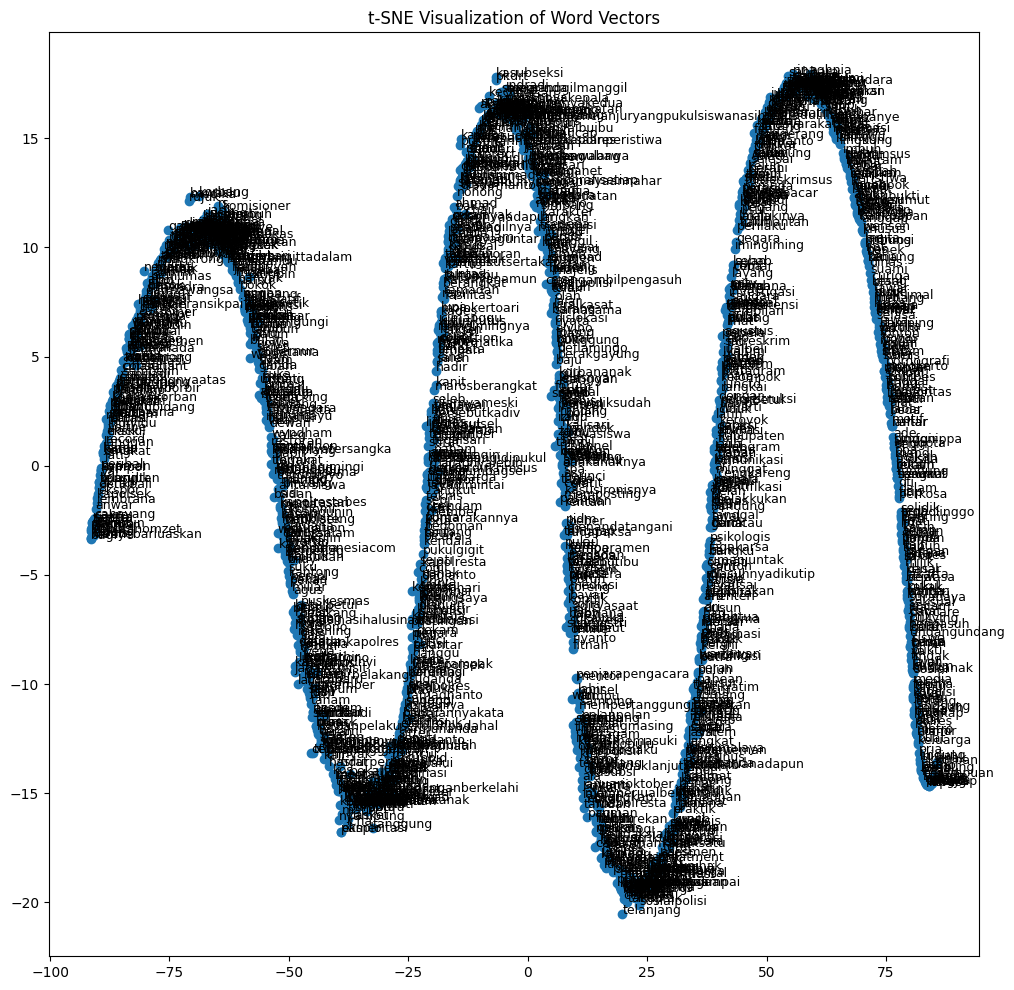

In [3]:
# Visualize t-SNE for the entire vocabulary
model.plot_tsne()

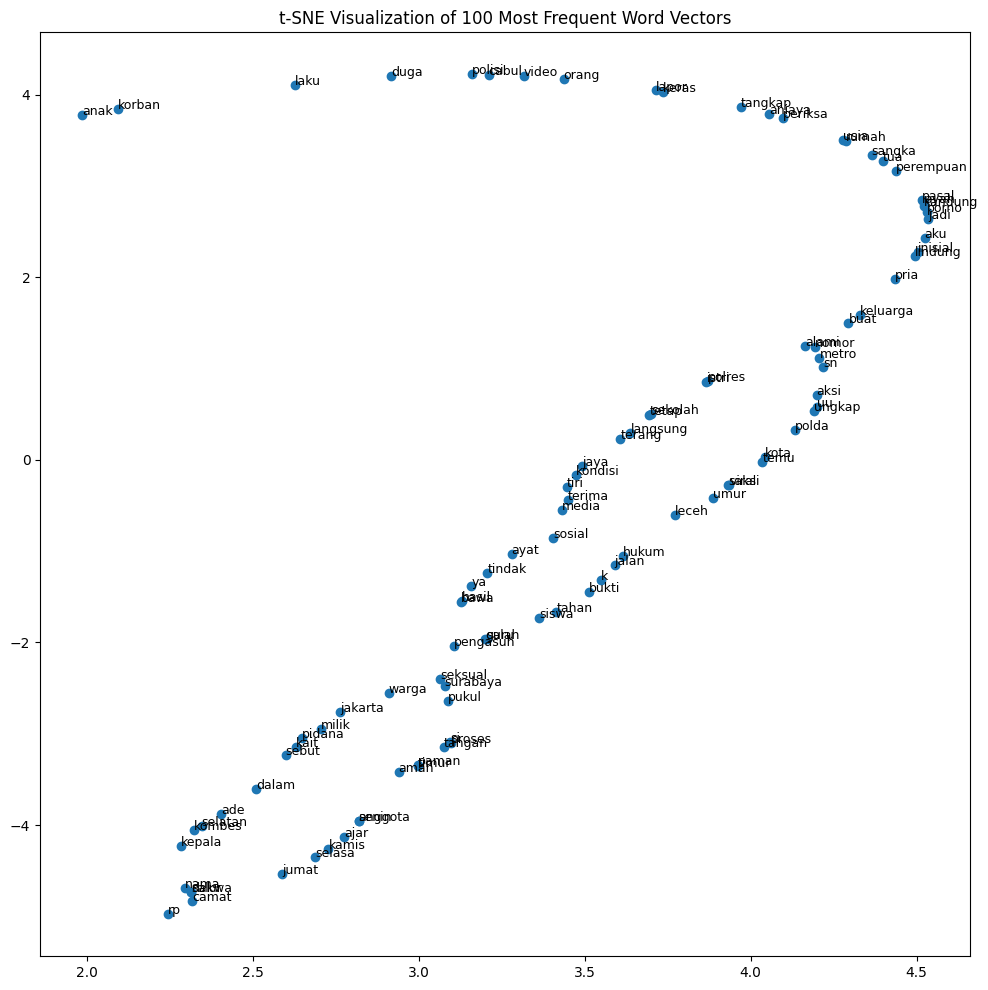

In [4]:
# Visualize t-SNE for the entire vocabulary based number of words
model.plot_tsne_num_words(num_words=100)

CSV file saved: word_frequencies_each_category.csv


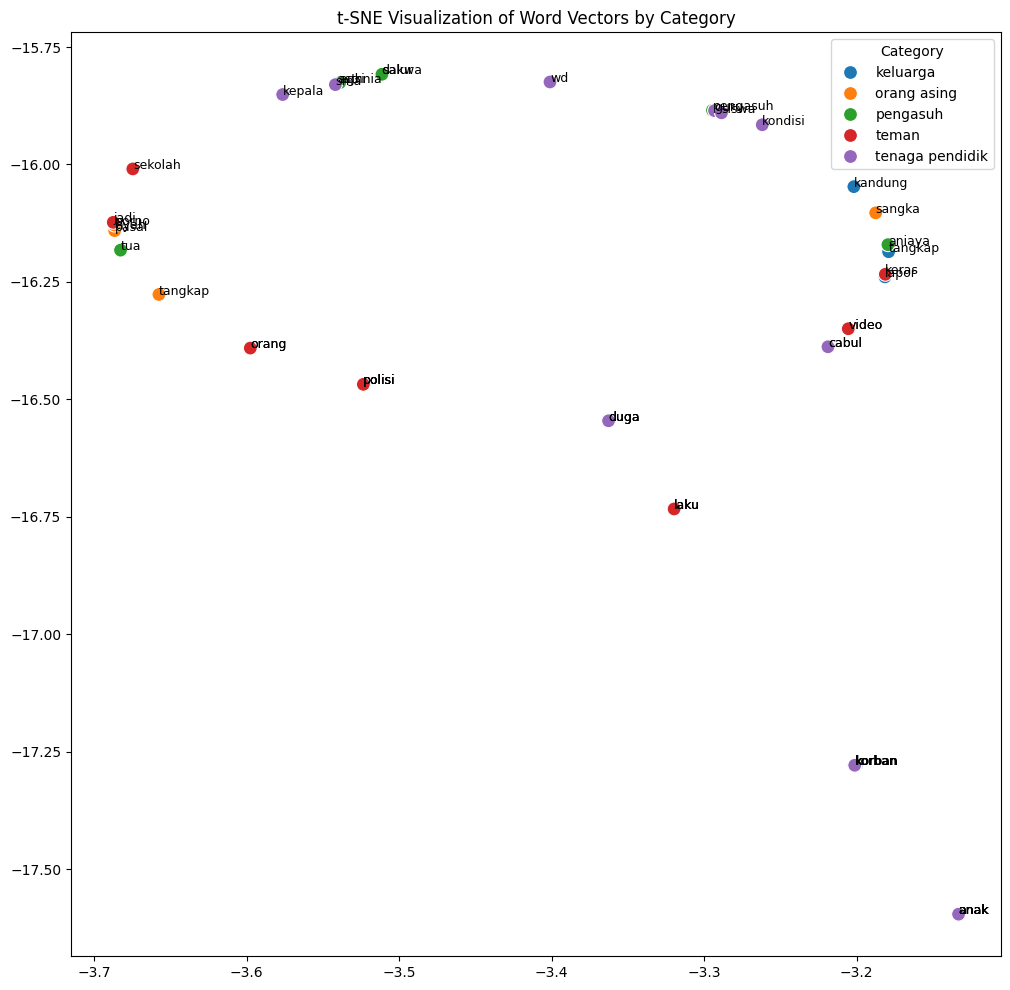

In [5]:
# Visualization of the most frequent words from each category
model.plot_tsne_most_frequent_word_by_category(num_words=10, save_csv=True, word_frequencies = 'word_frequencies_each_category.csv')